In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import logging
from xgboost import XGBClassifier


In [5]:
pip install xgboost


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
train_values = pd.read_csv('train_values.csv')
train_labels = pd.read_csv('train_labels.csv')

In [7]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [8]:
# Merge datasets

data = pd.merge(train_values, train_labels, on='building_id')
data.drop('building_id', axis=1, inplace=True)
logging.info("Data loaded and merged successfully.")

2025-10-01 23:11:39,912 - INFO - Data loaded and merged successfully.


In [9]:
# After loading and merging data
print("Columns in DataFrame:")
print(data.columns.tolist())


Columns in DataFrame:
['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 'legal_ownership_status', 'count_families', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use

In [10]:
# Drop building_id as it's not a feature

data.drop('building_id', axis=1, inplace=True)

KeyError: "['building_id'] not found in axis"

In [11]:
logging.info(data.info())
logging.info(data.describe())

2025-10-01 23:12:17,086 - INFO - None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-null 

2025-10-01 23:12:17,530 - INFO -        geo_level_1_id  geo_level_2_id  geo_level_3_id  count_floors_pre_eq  \
count   260601.000000   260601.000000   260601.000000        260601.000000   
mean        13.900353      701.074685     6257.876148             2.129723   
std          8.033617      412.710734     3646.369645             0.727665   
min          0.000000        0.000000        0.000000             1.000000   
25%          7.000000      350.000000     3073.000000             2.000000   
50%         12.000000      702.000000     6270.000000             2.000000   
75%         21.000000     1050.000000     9412.000000             2.000000   
max         30.000000     1427.000000    12567.000000             9.000000   

                 age  area_percentage  height_percentage  \
count  260601.000000    260601.000000      260601.000000   
mean       26.535029         8.018051           5.434365   
std        73.565937         4.392231           1.918418   
min         0.000000    

In [12]:
logging.info(data.describe())
print(data.describe)

2025-10-01 23:12:23,422 - INFO -        geo_level_1_id  geo_level_2_id  geo_level_3_id  count_floors_pre_eq  \
count   260601.000000   260601.000000   260601.000000        260601.000000   
mean        13.900353      701.074685     6257.876148             2.129723   
std          8.033617      412.710734     3646.369645             0.727665   
min          0.000000        0.000000        0.000000             1.000000   
25%          7.000000      350.000000     3073.000000             2.000000   
50%         12.000000      702.000000     6270.000000             2.000000   
75%         21.000000     1050.000000     9412.000000             2.000000   
max         30.000000     1427.000000    12567.000000             9.000000   

                 age  area_percentage  height_percentage  \
count  260601.000000    260601.000000      260601.000000   
mean       26.535029         8.018051           5.434365   
std        73.565937         4.392231           1.918418   
min         0.000000    

<bound method NDFrame.describe of         geo_level_1_id  geo_level_2_id  geo_level_3_id  count_floors_pre_eq  \
0                    6             487           12198                    2   
1                    8             900            2812                    2   
2                   21             363            8973                    2   
3                   22             418           10694                    2   
4                   11             131            1488                    3   
...                ...             ...             ...                  ...   
260596              25            1335            1621                    1   
260597              17             715            2060                    2   
260598              17              51            8163                    3   
260599              26              39            1851                    2   
260600              21               9            9101                    3   

        age  area

In [13]:
# Check for missing values 

missing = data.isnull().sum()
logging.info(f"Missing values:\n{missing[missing > 0]}")
print(missing[missing > 0])

2025-10-01 23:12:26,029 - INFO - Missing values:
Series([], dtype: int64)


Series([], dtype: int64)


2025-10-01 23:12:29,306 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-01 23:12:29,584 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


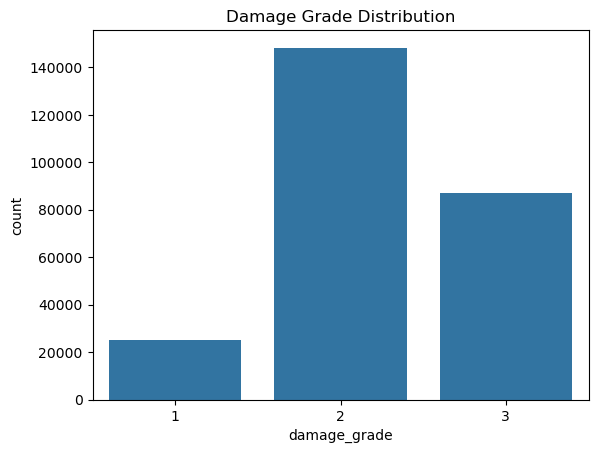

In [14]:
# Target distribution (check imbalance)
sns.countplot(x='damage_grade', data=data)
plt.title('Damage Grade Distribution')
plt.show()

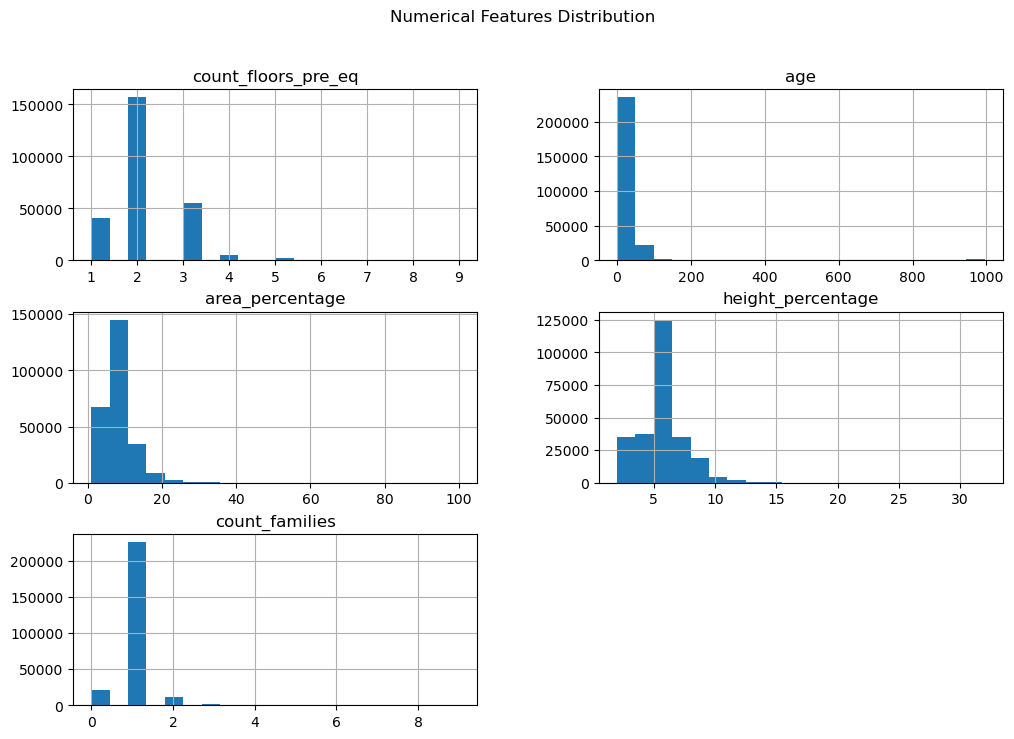

In [15]:
# Numerical features distribution
num_cols = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']
data[num_cols].hist(bins=20, figsize=(12, 8))
plt.suptitle('Numerical Features Distribution')
plt.show()

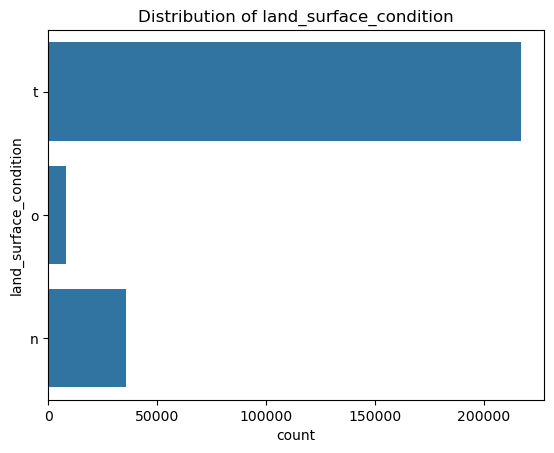

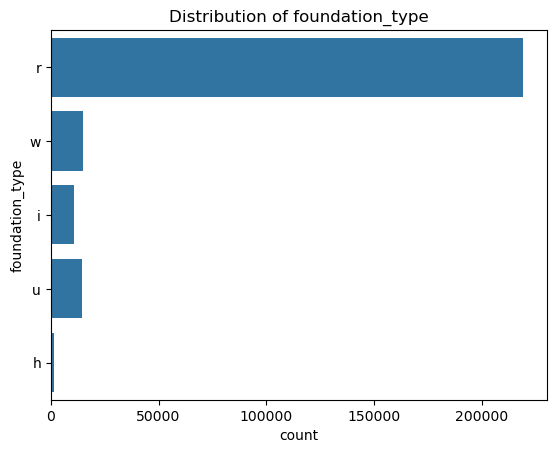

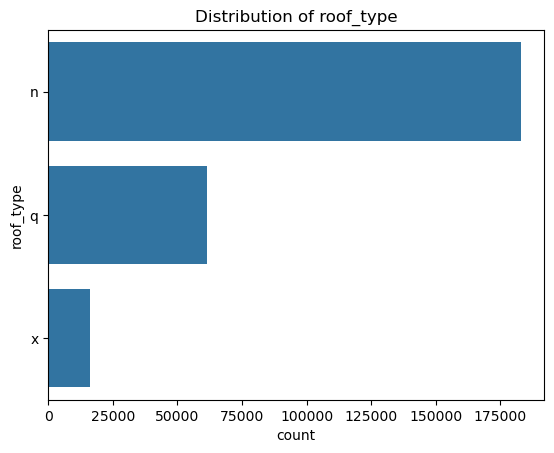

In [16]:
# Categorical features (sample)
cat_cols = [col for col in data.columns if data[col].dtype == 'object']
for col in cat_cols[:3]:  # Limit for brevity
    sns.countplot(y=col, data=data)
    plt.title(f'Distribution of {col}')
    plt.show()

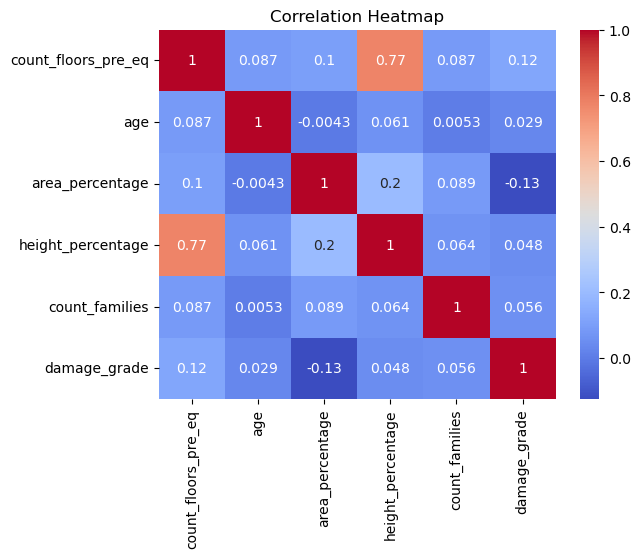

In [17]:
# Correlation heatmap (numerical only)
corr = data[num_cols + ['damage_grade']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

2025-10-01 23:12:44,522 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-01 23:12:44,770 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


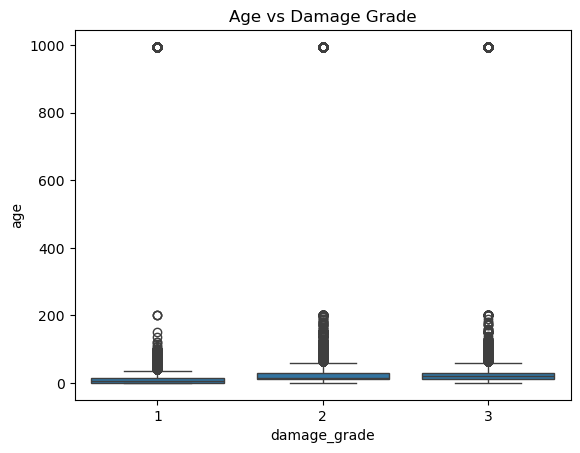

In [18]:
# Outlier detection (e.g., age > 100 might be outliers)
sns.boxplot(x='damage_grade', y='age', data=data)
plt.title('Age vs Damage Grade')
plt.show()

In [20]:
# Verify column existence
def check_columns(df, required_cols, step_name=""):
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        logging.error(f"Missing columns in {step_name}: {missing_cols}")
        raise KeyError(f"Columns {missing_cols} not found in DataFrame")
    logging.info(f"All required columns present for {step_name}.")

In [21]:

# Define feature types
geo_cols = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
num_cols = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']
cat_cols = ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 
            'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status']
binary_cols = [col for col in data.columns if col.startswith('has_') and col != 'has_secondary_use']

In [22]:
# Check for required columns before preprocessing
required_cols = geo_cols + num_cols + cat_cols + binary_cols + ['damage_grade']
check_columns(data, required_cols, "initial check")

2025-10-01 23:14:26,008 - INFO - All required columns present for initial check.


In [23]:

# Feature engineering 
if 'total_height' not in data.columns:
    data['total_height'] = data['count_floors_pre_eq'] * data['height_percentage']
    data['age_squared'] = data['age'] ** 2
    data['material_strength'] = (data['has_superstructure_cement_mortar_brick'] + 
                                 data['has_superstructure_rc_engineered'])
    num_cols += ['total_height', 'age_squared', 'material_strength']
    logging.info("Feature engineering completed: added total_height, age_squared, material_strength")

2025-10-01 23:14:36,165 - INFO - Feature engineering completed: added total_height, age_squared, material_strength


In [24]:

# Frequency encoding for geo column 
geo_freq_cols = [col + '_freq' for col in geo_cols]
if not all(col in data.columns for col in geo_freq_cols):
    check_columns(data, geo_cols, "frequency encoding")
    for col in geo_cols:
        freq = data[col].value_counts(normalize=True)
        data[col + '_freq'] = data[col].map(freq)
        logging.info(f"Frequency encoding for {col}:\n{freq.head()}")
    num_cols += geo_freq_cols
    data.drop(geo_cols, axis=1, inplace=True)
    logging.info(f"Dropped original geo columns. New columns: {data.columns.tolist()}")
else:
    logging.info("Geo frequency columns already exist, skipping encoding.")

2025-10-01 23:14:52,906 - INFO - All required columns present for frequency encoding.
2025-10-01 23:14:52,917 - INFO - Frequency encoding for geo_level_1_id:
geo_level_1_id
6     0.093557
26    0.086780
10    0.084723
17    0.083703
8     0.073215
Name: proportion, dtype: float64
2025-10-01 23:14:52,926 - INFO - Frequency encoding for geo_level_2_id:
geo_level_2_id
39      0.015495
158     0.009670
181     0.007982
1387    0.007828
157     0.007279
Name: proportion, dtype: float64
2025-10-01 23:14:52,935 - INFO - Frequency encoding for geo_level_3_id:
geo_level_3_id
633      0.002498
9133     0.002483
621      0.002034
11246    0.001804
2005     0.001788
Name: proportion, dtype: float64
2025-10-01 23:14:52,994 - INFO - Dropped original geo columns. New columns: ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adob

In [25]:
# Cap outliers in age
data['age'] = np.clip(data['age'], 0, 100)
logging.info(f"Age capped at 100. Stats:\n{data['age'].describe()}")

2025-10-01 23:15:00,913 - INFO - Age capped at 100. Stats:
count    260601.000000
mean         21.656229
std          19.800349
min           0.000000
25%          10.000000
50%          15.000000
75%          30.000000
max         100.000000
Name: age, dtype: float64


In [26]:
# Inspect preprocessed data
logging.info(f"Preprocessed DataFrame sample:\n{data.head()}")
logging.info(f"Columns after preprocessing: {data.columns.tolist()}")

2025-10-01 23:15:05,898 - INFO - Preprocessed DataFrame sample:
   count_floors_pre_eq  age  area_percentage  height_percentage  \
0                    2   30                6                  5   
1                    2   10                8                  7   
2                    2   10                5                  5   
3                    2   10                6                  5   
4                    3   30                8                  9   

  land_surface_condition foundation_type roof_type ground_floor_type  \
0                      t               r         n                 f   
1                      o               r         n                 x   
2                      t               r         n                 f   
3                      t               r         n                 f   
4                      t               r         n                 f   

  other_floor_type position  ... has_secondary_use_gov_office  \
0                q        t  ...   

In [27]:
# Split data
X = data.drop('damage_grade', axis=1)
y = data['damage_grade'] - 1  # XGBoost expects 0-2 labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
logging.info(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

2025-10-01 23:15:11,977 - INFO - Train shape: (208480, 41), Test shape: (52121, 41)


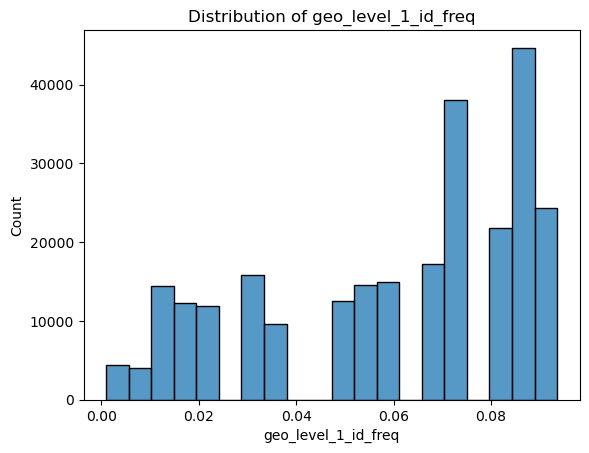

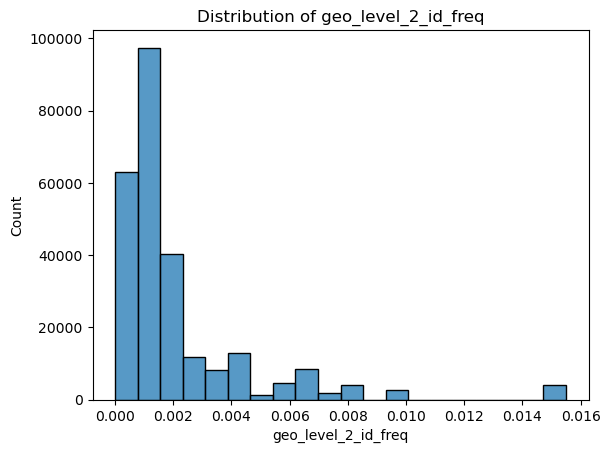

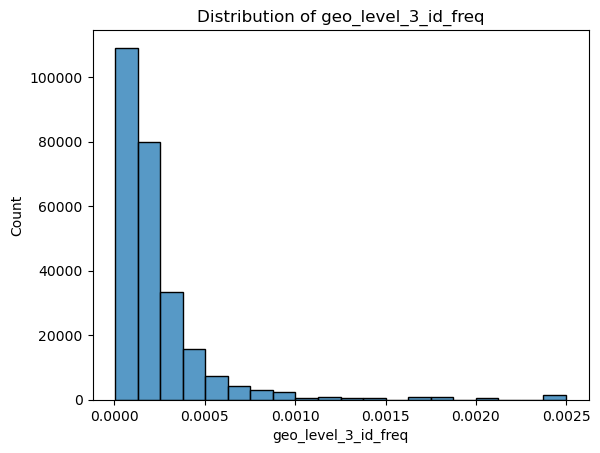

In [28]:
# Visualize frequency-encoded geo features
for col in geo_freq_cols:
    sns.histplot(data[col], bins=20)
    plt.title(f'Distribution of {col}')
    plt.show()

In [29]:
# Split data
X = data.drop('damage_grade', axis=1)
y = data['damage_grade'] - 1  # Adjust for 0-based indexing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
logging.info(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

2025-10-01 23:15:18,670 - INFO - Train shape: (208480, 41), Test shape: (52121, 41)


In [30]:

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
        ('bin', 'passthrough', binary_cols)
    ]
)

In [31]:
# Apply preprocessing and inspect output
X_train_transformed = preprocessor.fit_transform(X_train)
feature_names = (num_cols + 
                 preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols).tolist() + 
                 binary_cols)
X_train_df = pd.DataFrame(X_train_transformed, columns=feature_names)
logging.info(f"Preprocessed X_train shape: {X_train_transformed.shape}")
logging.info(f"Sample of preprocessed X_train:\n{X_train_df.head()}")
logging.info(f"Feature names after preprocessing: {feature_names[:10]}...")

2025-10-01 23:15:24,146 - INFO - Preprocessed X_train shape: (208480, 70)
2025-10-01 23:15:24,159 - INFO - Sample of preprocessed X_train:
   count_floors_pre_eq       age  area_percentage  height_percentage  \
0             1.197536 -0.084212        -0.458306           0.297285   
1            -0.178044 -0.084212        -0.458306          -0.226390   
2             1.197536  1.177265        -0.458306          -0.226390   
3            -0.178044 -0.588802        -0.231009          -0.226390   
4            -0.178044 -1.093393         0.223585           0.297285   

   count_families  total_height  age_squared  material_strength  \
0        0.039014      0.596800    -0.079267          -0.298058   
1        0.039014     -0.294562    -0.079267          -0.298058   
2        7.211517      0.262539    -0.056700          -0.298058   
3        0.039014     -0.294562    -0.083433          -0.298058   
4        0.039014     -0.071721    -0.084821          -0.298058   

   geo_level_1_id_freq  g

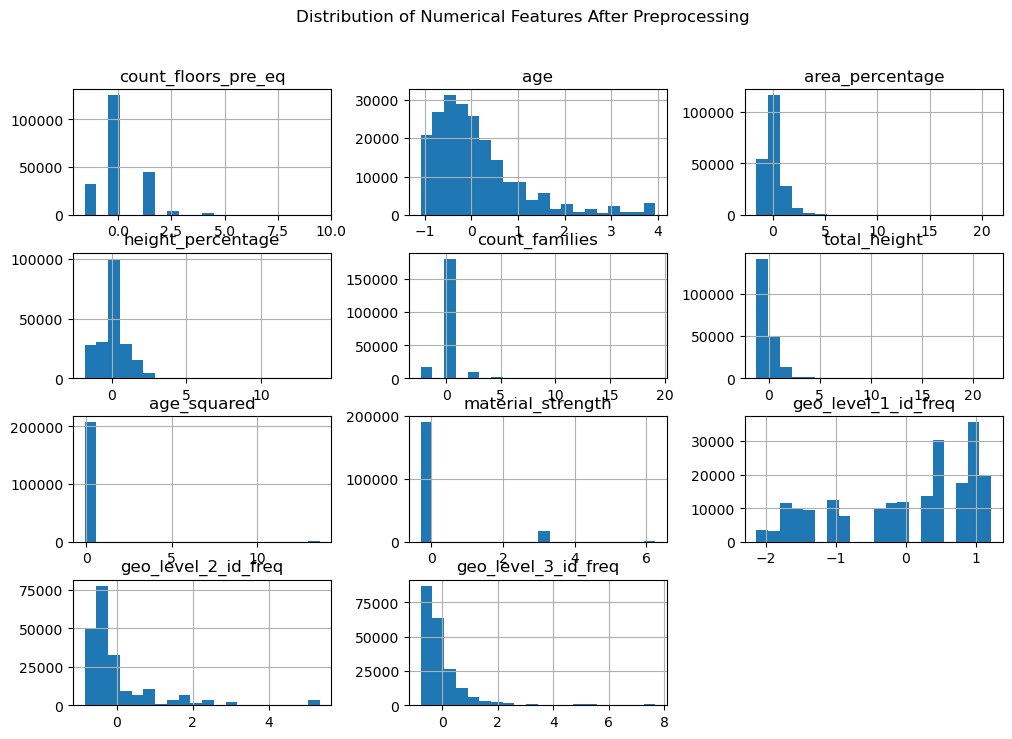

In [32]:
# Visualize a few preprocessed numerical features
X_train_df[num_cols].hist(bins=20, figsize=(12, 8))
plt.suptitle('Distribution of Numerical Features After Preprocessing')
plt.show()

In [33]:
# Model Training

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

In [34]:
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
import logging

In [40]:
# RandomForest Baseline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
f1_rf = f1_score(y_test, y_pred_rf, average='micro')
logging.info(f"RandomForest F1 (micro): {f1_rf:.4f}")
logging.info(f"RandomForest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(rf_pipeline)

2025-10-01 23:21:58,525 - INFO - RandomForest F1 (micro): 0.7160
2025-10-01 23:21:58,530 - INFO - RandomForest Accuracy: 0.7160


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['count_floors_pre_eq', 'age',
                                                   'area_percentage',
                                                   'height_percentage',
                                                   'count_families',
                                                   'total_height',
                                                   'age_squared',
                                                   'material_strength',
                                                   'geo_level_1_id_freq',
                                                   'geo_level_2_id_freq',
                                                   'geo_level_3_id_freq']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                         

In [41]:
# XGBoost with SMOTE
xgb_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42, eval_metric='mlogloss'))
])
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
f1_xgb = f1_score(y_test, y_pred_xgb, average='micro')
logging.info(f"XGBoost F1 (micro): {f1_xgb:.4f}")
logging.info(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")

2025-10-01 23:23:30,212 - INFO - XGBoost F1 (micro): 0.7155
2025-10-01 23:23:30,216 - INFO - XGBoost Accuracy: 0.7155


In [42]:
# 1. XGBoost with SMOTE (Advanced Model)
logging.info("Training XGBoost with SMOTE...")
xgb_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42, eval_metric='mlogloss', n_jobs=-1))
])
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
f1_xgb = f1_score(y_test, y_pred_xgb, average='micro')
acc_xgb = accuracy_score(y_test, y_pred_xgb)
logging.info(f"XGBoost F1 (micro): {f1_xgb:.4f}")
logging.info(f"XGBoost Accuracy: {acc_xgb:.4f}")

2025-10-01 23:23:30,229 - INFO - Training XGBoost with SMOTE...
2025-10-01 23:24:57,497 - INFO - XGBoost F1 (micro): 0.7155
2025-10-01 23:24:57,499 - INFO - XGBoost Accuracy: 0.7155


In [43]:
# Detailed evaluation for XGBoost
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Low', 'Medium', 'High']))

XGBoost Classification Report:
              precision    recall  f1-score   support

         Low       0.61      0.54      0.57      5025
      Medium       0.73      0.80      0.76     29652
        High       0.71      0.63      0.67     17444

    accuracy                           0.72     52121
   macro avg       0.68      0.65      0.67     52121
weighted avg       0.71      0.72      0.71     52121



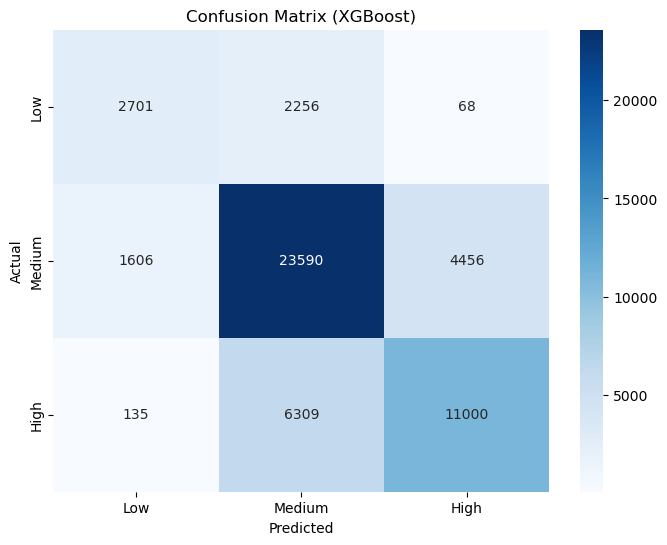

In [45]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], 
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix (XGBoost)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

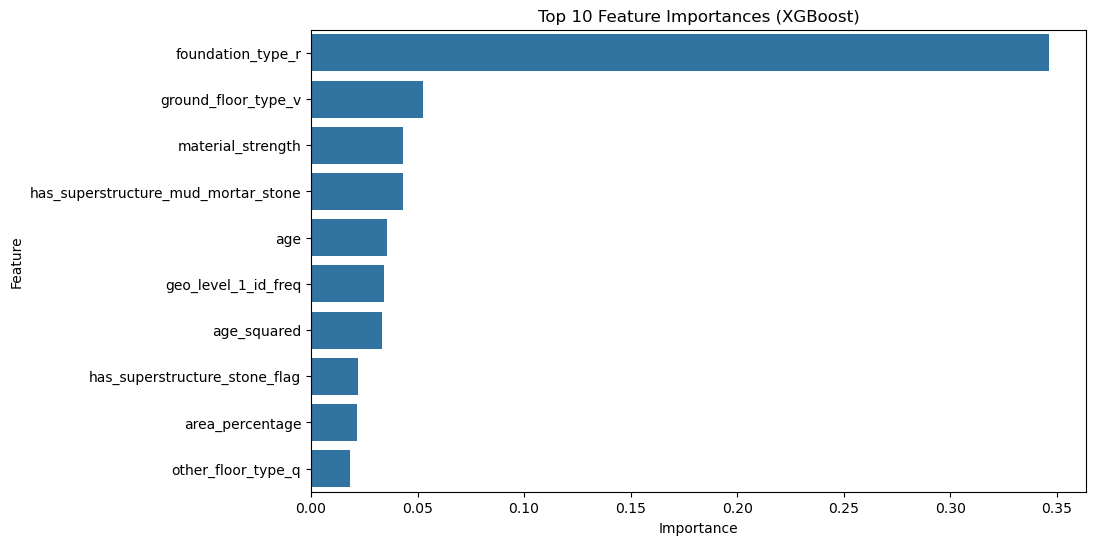

In [46]:
# Feature Importance (XGBoost)
importances = xgb_pipeline.named_steps['classifier'].feature_importances_
imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values('Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=imp_df.head(10))
plt.title('Top 10 Feature Importances (XGBoost)')
plt.show()

In [47]:
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
import logging

In [49]:
# Assuming X_train, X_test, y_train, y_test, preprocessor, num_cols, cat_cols, binary_cols are from preprocessing

# 1. XGBoost with SMOTE (Advanced Model)
logging.info("Training XGBoost with SMOTE...")
xgb_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42, eval_metric='mlogloss', n_jobs=-1))
])
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
f1_xgb = f1_score(y_test, y_pred_xgb, average='micro')
acc_xgb = accuracy_score(y_test, y_pred_xgb)
logging.info(f"XGBoost F1 (micro): {f1_xgb:.4f}")
logging.info(f"XGBoost Accuracy: {acc_xgb:.4f}")

2025-10-01 23:26:27,338 - INFO - Training XGBoost with SMOTE...
2025-10-01 23:28:04,530 - INFO - XGBoost F1 (micro): 0.7155
2025-10-01 23:28:04,532 - INFO - XGBoost Accuracy: 0.7155


In [50]:
# 2. Detailed Evaluation
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Low (1)', 'Medium (2)', 'High (3)']))


XGBoost Classification Report:
              precision    recall  f1-score   support

     Low (1)       0.61      0.54      0.57      5025
  Medium (2)       0.73      0.80      0.76     29652
    High (3)       0.71      0.63      0.67     17444

    accuracy                           0.72     52121
   macro avg       0.68      0.65      0.67     52121
weighted avg       0.71      0.72      0.71     52121



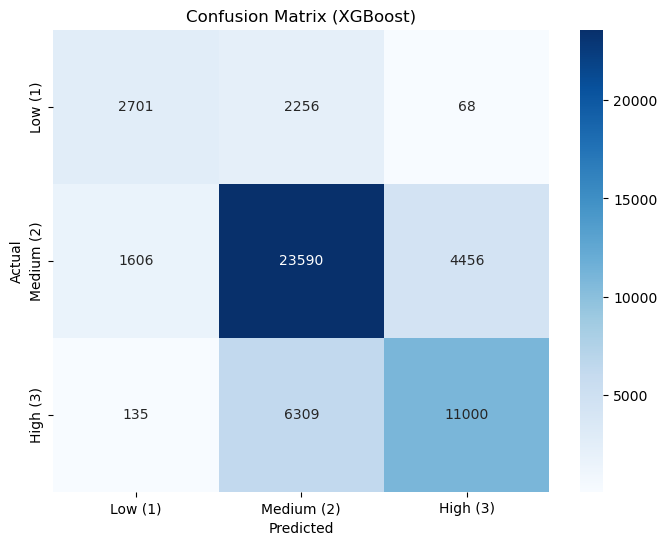

In [51]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low (1)', 'Medium (2)', 'High (3)'], 
            yticklabels=['Low (1)', 'Medium (2)', 'High (3)'])
plt.title('Confusion Matrix (XGBoost)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [52]:
# 3. Hyperparameter Tuning
logging.info("Tuning XGBoost hyperparameters...")
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6],
    'classifier__learning_rate': [0.01, 0.1]
}
grid_search = GridSearchCV(
    xgb_pipeline, param_grid, cv=3, scoring='f1_micro', n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
logging.info(f"Best hyperparameters: {grid_search.best_params_}")

2025-10-01 23:28:05,459 - INFO - Tuning XGBoost hyperparameters...


Fitting 3 folds for each of 8 candidates, totalling 24 fits


2025-10-01 23:58:48,289 - INFO - Best hyperparameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 200}


In [ ]:
# Evaluate tuned model
y_pred_best = best_model.predict(X_test)
f1_best = f1_score(y_test, y_pred_best, average='micro')
acc_best = accuracy_score(y_test, y_pred_best)
logging.info(f"Tuned XGBoost F1 (micro): {f1_best:.4f}")
logging.info(f"Tuned XGBoost Accuracy: {acc_best:.4f}")

In [ ]:
# 4. Cross-Validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1_micro')
logging.info(f"Cross-validation F1 scores: {cv_scores}")
logging.info(f"CV Mean F1: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

In [ ]:
# 5. Feature Importance
feature_names = (num_cols + 
                 best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_cols).tolist() + 
                 binary_cols)
importances = best_model.named_steps['classifier'].feature_importances_
imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values('Importance', ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=imp_df.head(15))
plt.title('Top 15 Feature Importances (Tuned XGBoost)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [ ]:
# 6. Save Model
joblib.dump(best_model, 'earthquake_damage_model.pkl')
logging.info("Best model saved as 'earthquake_damage_model.pkl'")